# 手动实现决策树

## 主要设计一下几个步骤：
- 数据集读取
- 熵的计算
- 数据集的划分（离散型和连续型）
- 决策树的生成

## 数据集读取

In [218]:
import pandas as pd
import numpy as np

import pprint

In [219]:
data = pd.read_csv(r"/home/kangaroo/project/LiHongYi/watermelon_3a.csv")

In [220]:
data

,Idx,color,root,knocks,texture,navel,touch,density,sugar_ratio,label
0,1,dark_green,curl_up,little_heavily,distinct,sinking,hard_smooth,0.697,0.460,1
1,2,black,curl_up,heavily,distinct,sinking,hard_smooth,0.774,0.376,1
2,3,black,curl_up,little_heavily,distinct,sinking,hard_smooth,0.634,0.264,1
3,4,dark_green,curl_up,heavily,distinct,sinking,hard_smooth,0.608,0.318,1
4,5,light_white,curl_up,little_heavily,distinct,sinking,hard_smooth,0.556,0.215,1
5,6,dark_green,little_curl_up,little_heavily,distinct,little_sinking,soft_stick,0.403,0.237,1
6,7,black,little_curl_up,little_heavily,little_blur,little_sinking,soft_stick,0.481,0.149,1
7,8,black,little_curl_up,little_heavily,distinct,little_sinking,hard_smooth,0.437,0.211,1
8,9,black,little_curl_up,heavily,little_blur,little_sinking,hard_smooth,0.666,0.091,0
9,10,dark_green,stiff,clear,distinct,even,soft_stick,0.243,0.267,0


## 计算香农熵

In [221]:
def calcShannonEnt(dataSet):
    '''
    dataSet 数据集
    
    根据熵的公式进行计算
    '''
    numEntries = len(dataSet)
    labelCounts = {}
    for featVec in dataSet:
        currentLabel = featVec[-1]
        if currentLabel not in labelCounts.keys():
            labelCounts[currentLabel] = 0
        labelCounts[currentLabel] += 1
        
    shannonEnt = 0.0

    for key in labelCounts:
        prob = float(labelCounts[key]) / numEntries
        shannonEnt -= prob * np.log2(prob)
    
    return shannonEnt

In [222]:
calcShannonEnt(data.values.tolist())

0.9975025463691153

## 划分数据集

### 离散型

In [223]:
def splitDataSet(dataSet, axis, value):
    '''
    dataSet 数据集
    axis 特征索引
    value 特征值
    
    获取特征索引为给定特征值的数据
    '''
    retDataSet = []
    for featVec in dataSet:
        if featVec[axis] == value:
            reducedFeatVec = featVec[:axis]
            reducedFeatVec.extend(featVec[axis+1:])
            retDataSet.append(reducedFeatVec)
    return retDataSet

In [224]:
splitDataSet(data.iloc[:, 1:-1].values.tolist(), 1, 'stiff')

[['dark_green', 'clear', 'distinct', 'even', 'soft_stick', 0.243, 0.267],
 ['light_white', 'clear', 'blur', 'even', 'hard_smooth', 0.245, 0.057]]

### 连续型

In [225]:
def splitContinuousDataSet(dataSet, axis, value, direction):
    '''
    dataSet 数据集
    axis 特征索引
    value 划分值
    direction 二分后对应的两部分   0， 特征值大于划分值的部分  
                                1， 特征值小于等于划分值的部分
    
    '''
    retDataSet = []
    for featVec in dataSet:
        if direction == 0:
            if featVec[axis] >  value:
                reduceFeatVec = featVec[:axis]
                reduceFeatVec.extend(featVec[axis+1 :])
                retDataSet.append(reduceFeatVec)
        else:
            if featVec[axis] <=  value:
                reduceFeatVec = featVec[:axis]
                reduceFeatVec.extend(featVec[axis+1 :])
                retDataSet.append(reduceFeatVec)
    return retDataSet

### 当特征集为空时，使用样本中最大类别最为该节点的类标记

In [226]:
import operator

def majorityCnt(classList):
    classCount = {}
    for vote in classList:
        if vote not in classCount.keys():
            classCount[vote] = 0
        classCount[vote] += 1

    sortedClassCount = sorted(classCount.items(), 
                              key = operator.itemgetter(1), reverse = True)
    return sortedClassCount[0][0]

In [227]:
majorityCnt(data.iloc[:,-1].values)

0

In [228]:
def chooseBestFeatureToSplit(dataSet):
    '''
    返回值:  连续型：特征索引、划分值
            离散型：特征索引
    '''
    numFeatures = len(dataSet[0]) - 1
    baseEntropy = calcShannonEnt(dataSet)
    bestInfoGain = 0.0
    bestFeature = -1
    for i in range(numFeatures):
        featList = [example[i] for example in dataSet]
        
        # 连续型数据
        if type(featList[0]).__name__ == "float" or type(featList[0]).__name__ == "int":
            sortedFeatList = sorted(featList)
            
            #　创建划分点列表，为每两个相邻的连续型数值相加除以二
            splitList = []
            for j in range(len(sortedFeatList) - 1):
                splitList.append((sortedFeatList[j] + sortedFeatList[j + 1]) / 2)
            
            #　记录连续型数据，对应最佳的划分值和最大的信息增量
            bestSplitInfoGain = 0.0
            bestSplit =  -1
            
            for j in range(len(splitList)):
                value = splitList[j]
                
                newEntropy = 0.0
                subDataSet_0 = splitContinuousDataSet(dataSet, i, value, 0)
                subDataSet_1 = splitContinuousDataSet(dataSet, i, value, 1)
                
                prob_0 = len(subDataSet_0) / len(dataSet)
                newEntropy += prob_0 * calcShannonEnt(subDataSet_0)
                
                prob_1 = len(subDataSet_1) / len(dataSet)
                newEntropy += prob_1 * calcShannonEnt(subDataSet_1)
                
                splitInfoGain = baseEntropy - newEntropy
                
                #　如果当前划分的信息增量大于　bestSplitInfoGain，则进行更新
                if splitInfoGain > bestSplitInfoGain:
                    bestSplitInfoGain = splitInfoGain
                    bestSplit = j
            
            #　如果当前特征最大的信息增量大于　bestInfoGain，则进行更新，注意和离散型不同的是，连续型不仅需要返回特征索引，还要返回划分值
            if bestSplitInfoGain > bestInfoGain:
                bestInfoGain = bestSplitInfoGain
                bestFeature = [i, splitList[bestSplit]]
                    
        
        # 离散型数据
        else:
            uniqueVals = set(featList)
            newEntropy = 0.0
            for value in uniqueVals:
                subDataSet = splitDataSet(dataSet, i, value)
                prob = len(subDataSet) / float(len(dataSet))
                newEntropy += prob * calcShannonEnt(subDataSet)
            infoGain = baseEntropy - newEntropy
            
            if infoGain > bestInfoGain:
                bestInfoGain = infoGain
                bestFeature = i

    return bestFeature

## 创建决策树

In [236]:
def createTree(dataSet, labels):
    classList = [example[-1] for example in dataSet]
    
    # case 1: 所有实例属于同一类
    if classList.count(classList[0]) == len(classList):
        return classList[0]
    # case 2: 特征集为空
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    
    bestFeat = chooseBestFeatureToSplit(dataSet)
    
    # 离散型特征
    if type(bestFeat).__name__ == "int":
        bestFeatLabel = labels[bestFeat]
#         print(bestFeat, labels[bestFeat])
    # 连续型特征
    else:
        bestFeatLabel = labels[bestFeat[0]]
#         print(bestFeat, labels[bestFeat[0]])
        
    myTree = {bestFeatLabel:{}}
    
    if type(bestFeat).__name__ == "int":
        del(labels[bestFeat])
        featValues = [example[bestFeat] for example in dataSet]
        uniqueVals = set(featValues)

        for value in uniqueVals:
            subLabels = labels[:]
            myTree[bestFeatLabel][value] = createTree(splitDataSet(dataSet, bestFeat, value), subLabels)
    else:
        del(labels[bestFeat[0]])
        featValues = [example[bestFeat[0]] for example in dataSet]
        
        for _ in range(2):
            symbol = "> " if _ == 0 else "<= "
            subLabels = labels[:]
            myTree[bestFeatLabel][symbol + str(bestFeat[1])] = createTree(splitContinuousDataSet(dataSet, bestFeat[0], bestFeat[1], _), subLabels)
        
    return myTree    

In [230]:
data.iloc[:,1:-3].join(data.iloc[:,-1])

,color,root,knocks,texture,navel,touch,label
0,dark_green,curl_up,little_heavily,distinct,sinking,hard_smooth,1
1,black,curl_up,heavily,distinct,sinking,hard_smooth,1
2,black,curl_up,little_heavily,distinct,sinking,hard_smooth,1
3,dark_green,curl_up,heavily,distinct,sinking,hard_smooth,1
4,light_white,curl_up,little_heavily,distinct,sinking,hard_smooth,1
5,dark_green,little_curl_up,little_heavily,distinct,little_sinking,soft_stick,1
6,black,little_curl_up,little_heavily,little_blur,little_sinking,soft_stick,1
7,black,little_curl_up,little_heavily,distinct,little_sinking,hard_smooth,1
8,black,little_curl_up,heavily,little_blur,little_sinking,hard_smooth,0
9,dark_green,stiff,clear,distinct,even,soft_stick,0


In [231]:
data.columns.tolist()[1:-3]

['color', 'root', 'knocks', 'texture', 'navel', 'touch']

In [237]:
pprint.pprint(createTree(data.iloc[:,1:-3].join(data.iloc[:,-1]).values.tolist(), data.columns.tolist()[1:-3]))

{'texture': {'blur': 0,
             'distinct': {'root': {'curl_up': 1,
                                   'little_curl_up': {'color': {'black': {'touch': {'hard_smooth': 1,
                                                                                    'soft_stick': 0}},
                                                                'dark_green': 1}},
                                   'stiff': 0}},
             'little_blur': {'touch': {'hard_smooth': 0, 'soft_stick': 1}}}}


In [238]:
data.iloc[:, 1:]

,color,root,knocks,texture,navel,touch,density,sugar_ratio,label
0,dark_green,curl_up,little_heavily,distinct,sinking,hard_smooth,0.697,0.460,1
1,black,curl_up,heavily,distinct,sinking,hard_smooth,0.774,0.376,1
2,black,curl_up,little_heavily,distinct,sinking,hard_smooth,0.634,0.264,1
3,dark_green,curl_up,heavily,distinct,sinking,hard_smooth,0.608,0.318,1
4,light_white,curl_up,little_heavily,distinct,sinking,hard_smooth,0.556,0.215,1
5,dark_green,little_curl_up,little_heavily,distinct,little_sinking,soft_stick,0.403,0.237,1
6,black,little_curl_up,little_heavily,little_blur,little_sinking,soft_stick,0.481,0.149,1
7,black,little_curl_up,little_heavily,distinct,little_sinking,hard_smooth,0.437,0.211,1
8,black,little_curl_up,heavily,little_blur,little_sinking,hard_smooth,0.666,0.091,0
9,dark_green,stiff,clear,distinct,even,soft_stick,0.243,0.267,0


In [239]:
pprint.pprint(createTree(data.iloc[:, 1:].values.tolist(), data.columns.tolist()[1:-1]))

{'texture': {'blur': 0,
             'distinct': {'density': {'<= 0.38149999999999995': 0,
                                      '> 0.38149999999999995': 1}},
             'little_blur': {'touch': {'hard_smooth': 0, 'soft_stick': 1}}}}


## 使用sklearn库生成决策树

In [240]:
def change(data):
    names = data.columns[:-1]
    for i in names:
        col = pd.Categorical(data[i])
        data[i] = col.codes
    return data

In [241]:
from sklearn.tree import DecisionTreeClassifier as DTC, export_graphviz

newdata = pd.DataFrame(change(data.iloc[:, 1:-2])).join(data.iloc[:, -2:])

X = newdata.iloc[:, 1:-1]
Y = newdata.iloc[:, -1]

dtc = DTC(criterion = "entropy")
dtc.fit(X, Y)

with open('/home/kangaroo/tree.dot', 'w') as f:
    f = export_graphviz(dtc, feature_names=X.columns, out_file=f)

In [245]:
import pydot

(graph,) = pydot.graph_from_dot_file('/home/kangaroo/tree.dot')
graph.write_png('/home/kangaroo/tree.png')
graph.write_pdf('/home/kangaroo/tree.pdf')

In [242]:
newdata

,color,root,knocks,texture,navel,touch,density,sugar_ratio,label
0,1,0,2,1,2,0,0.697,0.460,1
1,0,0,1,1,2,0,0.774,0.376,1
2,0,0,2,1,2,0,0.634,0.264,1
3,1,0,1,1,2,0,0.608,0.318,1
4,2,0,2,1,2,0,0.556,0.215,1
5,1,1,2,1,1,1,0.403,0.237,1
6,0,1,2,2,1,1,0.481,0.149,1
7,0,1,2,1,1,0,0.437,0.211,1
8,0,1,1,2,1,0,0.666,0.091,0
9,1,2,0,1,0,1,0.243,0.267,0


## 绘制决策树

In [135]:
a = {'texture': {'blur': 0,
             'distinct': {'density': {'<=0.381': 0,
                                      '>0.381': 1}},
             'little_blur': {'touch': {'hard_smooth': 0, 'soft_stick': 1}}}}

In [121]:
b = {'texture': {'blur': 0,
             'distinct': {'density': {'1': 0,
                                      '2': 1,
                                      '3': 2,
                                      '4': 3,}}}}

In [156]:
import matplotlib.pyplot as plt

# 内部节点样式
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
# 叶子节点样式
leafNode =  dict(boxstyle="round4", fc="0.8")
# 箭头由数据点指向注释
arrow_args = dict(arrowstyle="<-")

# 获取叶子节点的个数
def getNumLeafs(myTree):
    numLeafs = 0
    # 划分特征
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    # 遍历按照特征值划分后的结果
    for key in secondDict.keys():
        # 类型为字典，表示还需要进一步选取特征
        if type(secondDict[key]).__name__ == "dict":
            numLeafs += getNumLeafs(secondDict[key])
        # 非字典（标签），表示到达树的叶子节点
        else:
            numLeafs += 1
    return numLeafs

# 获取树的深度
def getTreeDepth(myTree):
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    for key in secondDict.keys():
        # 此节点为树的中间节点
        if type(secondDict[key]).__name__ == "dict":
            thisDepth = 1 + getTreeDepth(secondDict[key])
        # 叶子节点
        else:
            thisDepth = 1
        # 保存目前为止最大的深度
        if thisDepth > maxDepth:
            maxDepth = thisDepth
    return maxDepth     

# 树的边上添加文本信息
def plotMidText(cntrPt, parentPt, txtString):
    '''
    cntrPt     子节点的坐标
    parentPt   父节点的坐标
    txtString  两者之间边上待添加的信息
    '''
    # 计算x坐标
    xMid = (parentPt[0] - cntrPt[0]) / 2.0 + cntrPt[0]
    # 计算y坐标
    yMid = (parentPt[1] - cntrPt[1]) / 2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString, fontsize=11)

# 绘制树
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    depth = getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    
    # 接下来三行主要绘制树中内部节点
    # 第一次调用时，cntrPt 和 parentPt一样， 并且nodeTxt为空，所以绘制树的根节点
    # 后面调用时，绘制内部节点，与其父亲节点之间的边（以及边上的信息）
    
    # 利用当前节点（内部节点）的叶子节点个数，来确定当前节点的x轴位置
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yOff)
#     print(plotTree.xOff,plotTree.yOff, cntrPt, parentPt)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    
    secondDict = myTree[firstStr]
    # 接下来绘制下一层的节点，计算y轴上的位置，（根据树的深度，每次减小 1 / depth）
    plotTree.yOff = plotTree.yOff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        # 遍历到树的内部节点
        if type(secondDict[key]).__name__ == "dict":
            plotTree(secondDict[key], cntrPt, str(key))
        # 遍历到树的叶子节点
        else:
            # 只有遍历到叶子节点时，才更新xOff
            # 相邻叶子节点x轴之间间隔为 1/叶子节点个数，第一个叶子节点x轴为，1/2/叶子节点个数
            plotTree.xOff = plotTree.xOff + 1.0 / plotTree.totalW
#             print("叶子节点：{0}, {1}".format((plotTree.xOff, plotTree.yOff), cntrPt))
            plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff), cntrPt, leafNode)
            plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    # 还原y轴的值
    plotTree.yOff = plotTree.yOff + 1.0 / plotTree.totalD

    
# 绘制树的节点和边
# 因为箭头类型用的 "<-"，所以箭头从数据点指向注释信息
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    '''
    nodeTxt  注释内容
    centerPt  注释坐标
    parentPt   数据点（被注释点的坐标）
    nodeType   注释边框的样式
    
    xycoords 设置 xy 的坐标系
    testcoords 设置 xytest 的坐标系
    
    axes fraction参数，0,0 is lower left of axes and 1,1 is upper right
    '''
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords="axes fraction", 
                            xytext=centerPt, textcoords="axes fraction",
                           va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)
    
# 绘制决策树，决策树以字典形式保存
def createPlot(inTree):
    fig = plt.figure(1, facecolor="white")
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    # 初始化坐标值
    plotTree.xOff = -1 / 2.0 /plotTree.totalW
    plotTree.yOff = 1.0
    # 绘制决策树
    plotTree(inTree, (0.5, 1.0), "")
    plt.show()

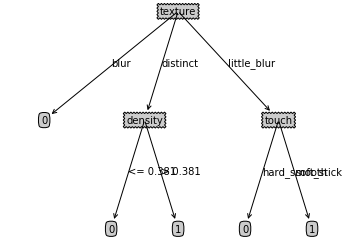

In [126]:
createPlot(a)

### 调整图片大小

#### 一、在createPlot函数创建plt.figuer时，添加参数figsize

fig = plt.figure(1, facecolor="white", figsize=(15.0, 8.0))

#### 二、 导入pylab库，设置如下

In [154]:
import pylab
pylab.rcParams['figure.figsize'] = (15.0, 8.0)

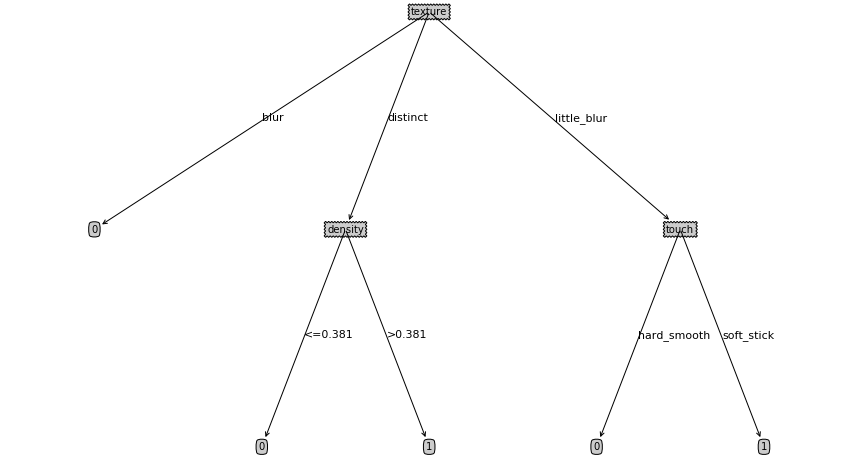

In [157]:
createPlot(a)